# Biodivine Models - External Inputs Analysis

This notebook analyzes external inputs (constants/signals) in biodivine boolean network models.

**Convertibility categories:**
- **Direct**: No external inputs - can be converted directly
- **With Substitution (≤3 inputs)**: Creates 2^n variations by substituting each input with 0 or 1
- **Not Convertible (>3 inputs)**: Too many variations would be created

In [9]:
import re
from pathlib import Path
from collections import defaultdict
import pandas as pd

SOURCE_DIR = Path(".")

In [10]:
def count_inputs(filepath):
    """Count variables and external inputs in a .bnet file."""
    functions = {}
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    for line in lines[1:]:
        line = line.strip()
        if not line or ',' not in line:
            continue
        parts = line.split(',', 1)
        if len(parts) != 2:
            continue
        var_name = parts[0].strip()
        expression = parts[1].strip()
        functions[var_name] = expression
    
    # Find all variable references
    all_refs = set()
    for expr in functions.values():
        refs = re.findall(r'\bv_\w+\b', expr)
        all_refs.update(refs)
    
    defined_vars = set(functions.keys())
    external_inputs = all_refs - defined_vars
    return len(functions), len(external_inputs), list(external_inputs)

In [11]:
# Analyze all networks from 4d to 16d
MAX_INPUTS = 3  # Models with up to 3 inputs can be converted via substitution
results = []

for dim in range(4, 17):
    dim_dir = SOURCE_DIR / f'{dim}d'
    if not dim_dir.exists():
        continue
    for bnet_file in sorted(dim_dir.glob('*.bnet')):
        num_vars, num_inputs, inputs = count_inputs(str(bnet_file))
        
        # Categorize convertibility
        if num_inputs == 0:
            category = 'Direct'
        elif num_inputs <= MAX_INPUTS:
            category = f'Substitution ({num_inputs} inputs → {2**num_inputs} files)'
        else:
            category = f'Not Convertible ({num_inputs} inputs)'
        
        results.append({
            'Dimension': dim,
            'File': bnet_file.name,
            'Variables': num_vars,
            'External Inputs': num_inputs,
            'Convertible': num_inputs <= MAX_INPUTS,
            'Category': category,
            'Input Names': ', '.join(sorted(inputs)[:3]) + ('...' if len(inputs) > 3 else '')
        })

df = pd.DataFrame(results)
print(f"Total models analyzed: {len(df)}")
print(f"Convertible (direct or substitution): {df['Convertible'].sum()}")
print(f"Not convertible (>{MAX_INPUTS} inputs): {(~df['Convertible']).sum()}")
df

Total models analyzed: 63
Convertible (direct or substitution): 39
Not convertible (>3 inputs): 24


,Dimension,File,Variables,External Inputs,Convertible,Category,Input Names
0,4,model_165_4d.bnet,4,4,False,Not Convertible (4 inputs),"v_BMP, v_EGF_b1, v_Roof_adj..."
1,4,model_170_4d.bnet,4,3,True,Substitution (3 inputs → 8 files),"v_Hb_b1, v_Hb_b3, v_Kni"
2,5,model_007_5d.bnet,5,0,True,Direct,
3,5,model_109_5d.bnet,5,0,True,Direct,
4,5,model_169_5d.bnet,5,2,True,Substitution (2 inputs → 4 files),"v_Hb_b1, v_Kni"
...,...,...,...,...,...,...,...
58,14,model_265_14d.bnet,14,3,True,Substitution (3 inputs → 8 files),"v_ELK1, v_SKI, v_SMARCE1"
59,15,model_057_15d.bnet,15,0,True,Direct,
60,15,model_208_15d.bnet,15,0,True,Direct,
61,16,model_024_16d.bnet,16,4,False,Not Convertible (4 inputs),"v_BuddingCP, v_Size, v_SpindleCP..."


## Summary by Dimension

In [12]:
# Summary table with new categories
summary = df.groupby('Dimension').agg(
    Total=('File', 'count'),
    Direct=('External Inputs', lambda x: (x == 0).sum()),
    With_Substitution=('External Inputs', lambda x: ((x > 0) & (x <= MAX_INPUTS)).sum()),
    Not_Convertible=('External Inputs', lambda x: (x > MAX_INPUTS).sum()),
    Convertible=('Convertible', 'sum')
).reset_index()

summary['Direct'] = summary['Direct'].astype(int)
summary['With_Substitution'] = summary['With_Substitution'].astype(int)
summary['Not_Convertible'] = summary['Not_Convertible'].astype(int)
summary['Convertible'] = summary['Convertible'].astype(int)

# Add totals row
totals = pd.DataFrame([{
    'Dimension': 'TOTAL',
    'Total': summary['Total'].sum(),
    'Direct': summary['Direct'].sum(),
    'With_Substitution': summary['With_Substitution'].sum(),
    'Not_Convertible': summary['Not_Convertible'].sum(),
    'Convertible': summary['Convertible'].sum()
}])

summary_with_totals = pd.concat([summary, totals], ignore_index=True)
summary_with_totals

,Dimension,Total,Direct,With_Substitution,Not_Convertible,Convertible
0,4,2,0,1,1,1
1,5,7,2,5,0,7
2,6,1,1,0,0,1
3,7,5,1,1,3,2
4,8,3,0,2,1,2
5,9,6,2,3,1,5
6,10,4,0,1,3,1
7,11,10,3,2,5,5
8,12,8,1,4,3,5
9,13,6,0,3,3,3


## Visualization

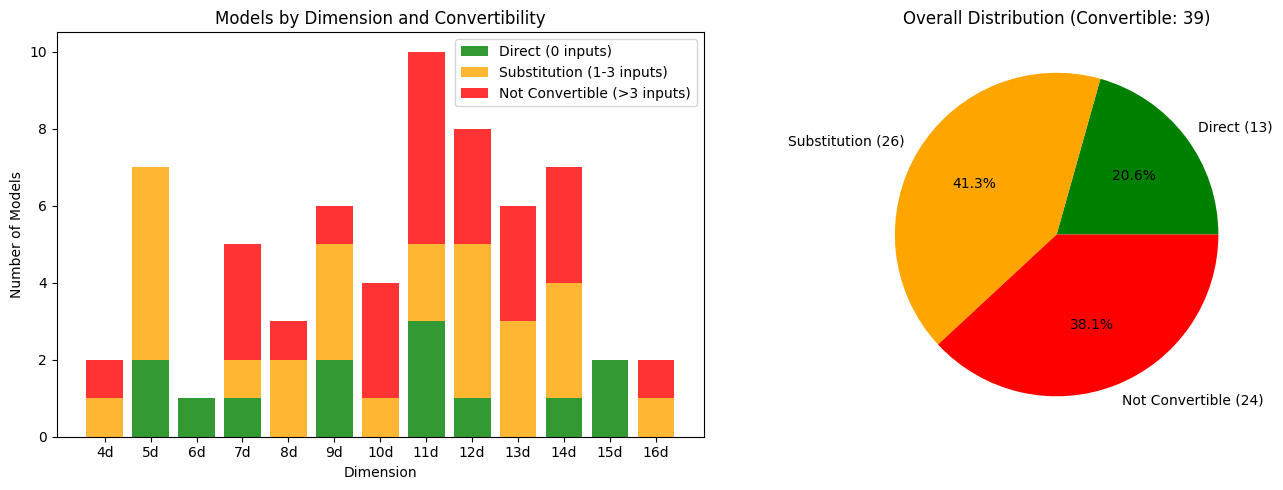

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Stacked bar showing Direct, With Substitution, Not Convertible
dims = summary['Dimension'].astype(str)
x = range(len(dims))

axes[0].bar(x, summary['Direct'], label='Direct (0 inputs)', color='green', alpha=0.8)
axes[0].bar(x, summary['With_Substitution'], bottom=summary['Direct'], 
            label=f'Substitution (1-{MAX_INPUTS} inputs)', color='orange', alpha=0.8)
axes[0].bar(x, summary['Not_Convertible'], 
            bottom=summary['Direct'] + summary['With_Substitution'],
            label=f'Not Convertible (>{MAX_INPUTS} inputs)', color='red', alpha=0.8)
axes[0].set_xlabel('Dimension')
axes[0].set_ylabel('Number of Models')
axes[0].set_title('Models by Dimension and Convertibility')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'{d}d' for d in dims])
axes[0].legend()

# Pie chart: Overall distribution by category
total_direct = summary['Direct'].sum()
total_substitution = summary['With_Substitution'].sum()
total_not_conv = summary['Not_Convertible'].sum()

axes[1].pie([total_direct, total_substitution, total_not_conv], 
            labels=[f'Direct ({total_direct})', 
                    f'Substitution ({total_substitution})', 
                    f'Not Convertible ({total_not_conv})'],
            colors=['green', 'orange', 'red'],
            autopct='%1.1f%%')
axes[1].set_title(f'Overall Distribution (Convertible: {total_direct + total_substitution})')

plt.tight_layout()
plt.show()

## Convertible Models (Direct + Substitution)

In [14]:
# Show all convertible models (direct + with substitution)
convertible_df = df[df['Convertible']][['Dimension', 'File', 'Variables', 'External Inputs', 'Category']]
print(f"Total convertible models: {len(convertible_df)}")
print(f"  - Direct (0 inputs): {(df['External Inputs'] == 0).sum()}")
print(f"  - With substitution (1-{MAX_INPUTS} inputs): {((df['External Inputs'] > 0) & (df['External Inputs'] <= MAX_INPUTS)).sum()}")
convertible_df

Total convertible models: 39
  - Direct (0 inputs): 13
  - With substitution (1-3 inputs): 26


,Dimension,File,Variables,External Inputs,Category
1,4,model_170_4d.bnet,4,3,Substitution (3 inputs → 8 files)
2,5,model_007_5d.bnet,5,0,Direct
3,5,model_109_5d.bnet,5,0,Direct
4,5,model_169_5d.bnet,5,2,Substitution (2 inputs → 4 files)
5,5,model_171_5d.bnet,5,2,Substitution (2 inputs → 4 files)
6,5,model_172_5d.bnet,5,2,Substitution (2 inputs → 4 files)
7,5,model_184_5d.bnet,5,1,Substitution (1 inputs → 2 files)
8,5,model_189_5d.bnet,5,1,Substitution (1 inputs → 2 files)
9,6,model_088_6d.bnet,6,0,Direct
11,7,model_158_7d.bnet,7,0,Direct


## Expected Output Files

Models with substitution create 2^n output files (one per input combination).

In [15]:
# Calculate expected output files
convertible_models = df[df['Convertible']].copy()
convertible_models['Output Files'] = convertible_models['External Inputs'].apply(lambda x: 2**x if x > 0 else 1)

files_by_dim = convertible_models.groupby('Dimension').agg(
    Models=('File', 'count'),
    Output_Files=('Output Files', 'sum')
).reset_index()

total_output_files = convertible_models['Output Files'].sum()
print(f"Expected output files: {total_output_files}")
print()
files_by_dim

Expected output files: 141



,Dimension,Models,Output_Files
0,4,1,8
1,5,7,18
2,6,1,1
3,7,2,9
4,8,2,8
5,9,5,10
6,10,1,8
7,11,5,13
8,12,5,19
9,13,3,16
